<AxesSubplot:ylabel='Frequency'>

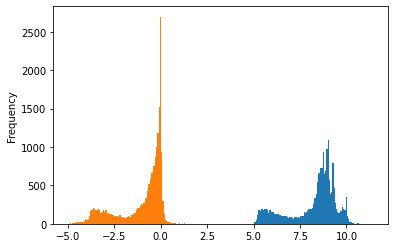

In [3]:
#Generate sequences for all mutations in deep mutational scan covid spike RBD experiment 
#! pip install Bio
import pandas as pd
import Bio
from Bio import SeqIO
from Bio import SeqRecord
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import matplotlib.pyplot as plt
from Bio.Seq import MutableSeq
#import tabulate

# read and get constants
url = 'https://media.githubusercontent.com/media/jbloomlab/SARS-CoV-2-RBD_DMS_variants/main/results/final_variant_scores/final_variant_scores.csv'
df = pd.read_csv(url) 

strains = df['target'].unique() # getting strain names from the df
pos = df['position'].unique()
aa = df['mutant'].unique()
plt.figure()
df['bind'].plot.hist(bins=100)
df['delta_bind'].plot.hist(bins=100)
#print(strains)
#print(type(pos))
#print(aa)

In [4]:
#strains = ['Beta', 'E484K', 'N501Y', 'Wuhan-Hu-1', 'Delta']
# vectorized computation is preferable to iteration
# define functions:
def get_wt(df, strain_name): # get wt seq
    dfStrain = df.loc[(df['target'] == strain_name) & (df['wildtype'] == df['mutant']) ] # get wt aa's for a strain
    aa = dfStrain['wildtype'].str.cat() # cat a series to a string
    return(aa)

def get_binds(df): # get bind values, with ref+mutation as key (tuple)
    dict1 = df[['target', 'mutation', 'position', 'wildtype', 'mutant', 'bind', 'delta_bind']].to_dict('records')
    dict2 = {}
    for i in dict1:
        dict2[ (i['target'], i['mutation']) ] = {'bind': i['bind'], 
                                                 'd_bind': i['delta_bind'], 
                                                 'ref': i['target'],
                                                 'pos': i['position'],
                                                 'wt': i['wildtype'],
                                                 'mut': i['mutant']
                                                }
    return(dict2)
#print(get_binds(df, 20))    

In [5]:
# collect all info (seq, bind) in rowDict
wtSeq = {} # store wt as a dict so it could be matached to bind values
wtSeqRec = []
for strain in strains: 
    seqRec = SeqRecord(
        Seq(get_wt(df, strain)),
        id = strain + "_WT",
        )
    wtSeq[strain]= seqRec
    wtSeqRec.append(seqRec)
#print(wtSeq)
with open("wt.fas","w") as out_fh:
  SeqIO.write(wtSeqRec, out_fh, 'fasta')

rowDict = get_binds(df)
wtDict = {}
mutDict = {}
for rec in rowDict:
    #print(rowDict[rec])
    if rowDict[rec]['wt'] == rowDict[rec]['mut']: # wt
        rowDict[rec]['seq'] = wtSeq[rec[0]]
        wtDict[rec[0]] = rowDict[rec]
    else: # mutant
        sequence = MutableSeq(wtSeq[rec[0]].seq)
        #print(sequence)
        #print(type(int(rowDict[rec]['pos'] - pos[0])))
        sequence[int(rowDict[rec]['pos'] - pos[0]) ] = rowDict[rec]['mut']
        #print(sequence)
        rowDict[rec]['seq'] = SeqRecord(Seq(sequence), id = rec[1])
        mutDict[rec] = rowDict[rec]
print([ [x, wtDict[x]['bind']] for x in wtDict])

[['Beta', 9.3071], ['E484K', 8.96107], ['N501Y', 9.95503], ['Wuhan-Hu-1', 8.77161], ['Delta', 9.03525]]


['Beta', 'E484K', 'N501Y', 'Wuhan-Hu-1', 'Delta', 'Beta_K484A', 'Beta_Y501A', 'E484K_K484A', 'E484K_N501A', 'N501Y_E484A', 'N501Y_Y501A', 'Wuhan-Hu-1_E484A', 'Wuhan-Hu-1_N501A', 'Delta_E484A', 'Delta_N501A']
[('Beta', 'N501Y'), ('E484K', 'Beta'), ('Wuhan-Hu-1', 'E484K'), ('Wuhan-Hu-1', 'N501Y'), ('Wuhan-Hu-1', 'Delta'), ('Delta', 'Delta_E484A'), ('Beta_K484A', 'Beta'), ('Beta_Y501A', 'Beta'), ('E484K_K484A', 'E484K'), ('E484K_N501A', 'E484K'), ('N501Y_E484A', 'N501Y'), ('N501Y_Y501A', 'N501Y'), ('Wuhan-Hu-1_E484A', 'Wuhan-Hu-1'), ('Wuhan-Hu-1_N501A', 'Wuhan-Hu-1'), ('Delta_N501A', 'Delta')]


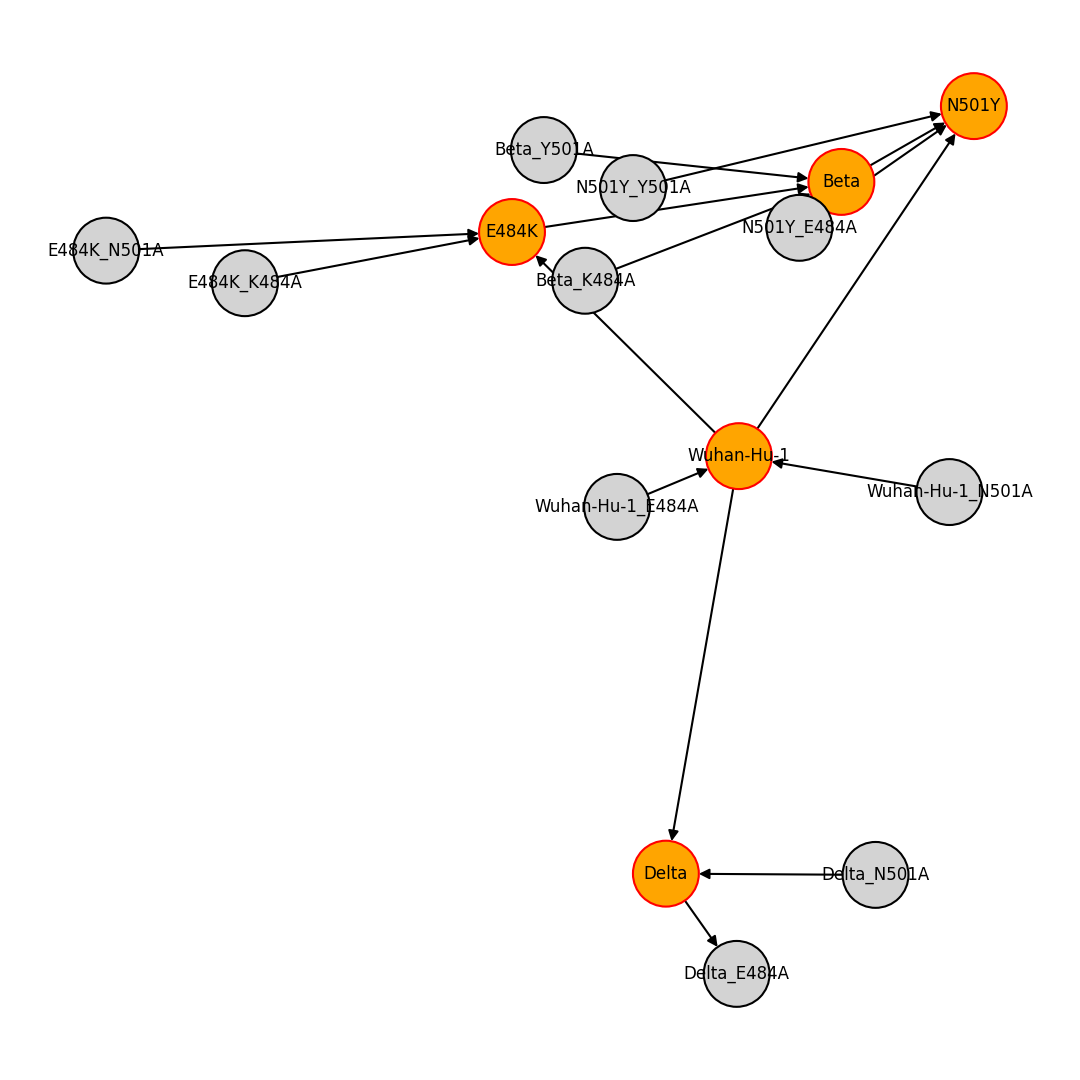

In [19]:
# build a directed graph
import networkx as nx

DG = nx.DiGraph() # a directed graph
for strain in wtDict: # add wt
    DG.add_node(strain)
    for k in wtDict[strain]:
        DG.nodes[strain][k] = wtDict[strain][k]

#pickSites = [417, 484, 501, 452, 478] # show these sites only
pickSites = [484, 501] # show these sites only
pickAAs = ['A']
pickRec = [ rec for rec in mutDict if (mutDict[rec]['pos'] in pickSites) & (mutDict[rec]['mut'] in pickAAs)  ]

for rec in pickRec: # add mut & edge
    id = rec[0] + "_" + rec[1]
    DG.add_node(id)
    for k in mutDict[rec]:
        DG.nodes[id][k] = mutDict[rec][k]

    if wtDict[rec[0]]['bind'] < mutDict[rec]['bind']: # higher bind for mut    
        DG.add_edge(rec[0], id)
    else:
        DG.add_edge(id, rec[0])
# add edges between WTs    
DG.add_edge(strains[3], strains[1]) # wuhan -> E484
DG.add_edge(strains[3], strains[2]) # wuhan -> N501
DG.add_edge(strains[1], strains[0]) # E484 -> beta
DG.add_edge(strains[0], strains[2]) # beta -> N501Y
DG.add_edge(strains[3], strains[4]) # wuhan -> delta
print(DG.nodes)
print(DG.edges)

plt.figure(figsize = (7,7), dpi=150)
nx.draw(DG, with_labels = True, 
        node_size = 1000,
        node_color = ['orange'] * 5 + ['lightgray'] * 10,
        edgecolors = ['red'] * 5 + ['black'] * 10,
        font_size = 8)
#plt.show()
plt.savefig("graph.png")
#print(DG.adj[strains[0]])
        


In [14]:
['red'] * 10 + ['black'] * 10

['red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black']